<a href="https://colab.research.google.com/github/laribar/SmartAITraderBot/blob/main/Bot_Funcional_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install ta
!pip install yfinance
!pip install xgboost

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=228728279a5d58ff3eb94e83ee3745e3a1ff91f7c67576bb4dd162854f7b7a70
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [7]:
# ====================================================
# 1. IMPORTAÇÕES
# ====================================================
import yfinance as yf
import numpy as np
import pandas as pd
import ta
import requests
import time  # Para usar time.sleep()
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
XGBClassifier(
    n_estimators=200,
    max_depth=4,                 # menor profundidade = menos overfitting
    subsample=0.8,               # usa 80% dos dados por árvore
    colsample_bytree=0.8,        # usa 80% das features por árvore
    learning_rate=0.05,          # suaviza o aprendizado
    early_stopping_rounds=10,    # para de treinar se não melhorar
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
# ====================================================
# BLOCO 1 - CONFIGURAÇÃO DE PASTAS E IMPORTS EXTRA
# ====================================================
import os
import joblib
from tensorflow.keras.models import load_model

# Criar pasta onde os modelos serão salvos
os.makedirs("/content/models", exist_ok=True)
# ====================================================
# BLOCO 2 - SALVAR E CARREGAR MODELOS TREINADOS
# ====================================================
def get_model_path(asset, interval, model_type="xgb"):
    asset_clean = asset.replace("-", "")
    ext = "joblib" if model_type == "xgb" else "h5"
    return f"/content/models/{model_type}_model_{asset_clean}_{interval}.{ext}"

# --- XGBoost ---
def save_xgb_model(model, asset, interval):
    path = get_model_path(asset, interval, model_type="xgb")
    joblib.dump(model, path)
    print(f"💾 Modelo XGBoost salvo em: {path}")

def load_xgb_model(asset, interval):
    path = get_model_path(asset, interval, model_type="xgb")
    if os.path.exists(path):
        print(f"📂 Modelo XGBoost carregado de: {path}")
        return joblib.load(path)
    return None

# --- LSTM ---
def save_lstm_model(model, asset, interval):
    path = get_model_path(asset, interval, model_type="lstm")
    model.save(path)
    print(f"💾 Modelo LSTM salvo em: {path}")

def load_lstm_model(asset, interval, data=None, window_size=20):
    from tensorflow.keras.models import load_model

    path = get_model_path(asset, interval, model_type="lstm")
    if os.path.exists(path):
        print(f"📂 Modelo LSTM carregado de: {path}")
        model = load_model(path)
        model.window_size = window_size

        if data is not None:
            # ⚠️ Reaplica corretamente o scaler com base nos dados reais
            _, _, scaler = prepare_lstm_data(data, window_size=window_size)
            model.scaler = scaler
        else:
            print("⚠️ Atenção: LSTM carregado sem dados para gerar o scaler!")
            model.scaler = None

        return model
    return None




# ====================================================
# 2. CONFIGURAÇÕES
# ====================================================
ASSETS = ["BTC-USD"] #, "ETH-USD", "BNB-USD", "SOL-USD", "XRP-USD", "AVAX-USD", "AAVE-USD", "DOT-USD", "NEAR-USD", "ADA-USD"


TIMEFRAMES = [
    {"interval": "15m", "period": "30d", "atr": 0.02},
    {"interval": "1h", "period": "90d", "atr": 0.03},
    {"interval": "1d", "period": "1000d", "atr": 0.05}
]

TELEGRAM_TOKEN = "8044593190:AAFtUWYHd3uqd-AtQi3uqg42F9G6uV95v8k"
TELEGRAM_CHAT_ID = "-4744645054"

# ====================================================
# 3. COLETA DE DADOS
# ====================================================
def get_stock_data(asset, interval="15m", period="700d"):
    data = yf.download(asset, period=period, interval=interval, progress=False, auto_adjust=False)
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    data.columns = [col.split()[-1] if " " in col else col for col in data.columns]
    data = data.loc[:, ~data.columns.duplicated()]
    col_map = {col: std_col for col in data.columns for std_col in ["Open", "High", "Low", "Close", "Adj Close", "Volume"] if std_col.lower() in col.lower()}
    data = data.rename(columns=col_map)
    data = data[["Open", "High", "Low", "Close", "Volume"]]
    if not all(col in data.columns for col in ["Open", "High", "Low", "Close", "Volume"]):
        raise ValueError(f"⚠️ Dados de {asset} não possuem todas as colunas necessárias.")
    return data


# ====================================================
# 4. INDICADORES TÉCNICOS
# ====================================================
def calculate_indicators(data):
    data = data.copy().reset_index(drop=True)
    for col in ["Open", "High", "Low", "Close", "Volume"]:
        data[col] = data[col].astype(float)
    data["RSI"] = ta.momentum.RSIIndicator(close=data["Close"], window=14).rsi()
    data["SMA_50"] = ta.trend.SMAIndicator(close=data["Close"], window=50).sma_indicator()
    data["SMA_200"] = ta.trend.SMAIndicator(close=data["Close"], window=200).sma_indicator()
    macd = ta.trend.MACD(close=data["Close"])
    data["MACD"] = macd.macd()
    data["MACD_Signal"] = macd.macd_signal()
    bb = ta.volatility.BollingerBands(close=data["Close"], window=20)
    data["Bollinger_Upper"] = bb.bollinger_hband()
    data["Bollinger_Lower"] = bb.bollinger_lband()
    adx = ta.trend.ADXIndicator(high=data["High"], low=data["Low"], close=data["Close"], window=14)
    data["ADX"] = adx.adx()
    stoch = ta.momentum.StochasticOscillator(high=data["High"], low=data["Low"], close=data["Close"], window=14)
    data["Stoch_K"] = stoch.stoch()
    data["Stoch_D"] = stoch.stoch_signal()
    data["TP"] = (data["High"] + data["Low"] + data["Close"]) / 3
    data["VWAP"] = (data["TP"] * data["Volume"]).cumsum() / (data["Volume"].replace(0, np.nan).cumsum())
    data.drop("TP", axis=1, inplace=True)
    data["Doji"] = ((abs(data["Close"] - data["Open"]) / (data["High"] - data["Low"] + 1e-9)) < 0.1).astype(int)
    data["Engulfing"] = ((data["Open"].shift(1) > data["Close"].shift(1)) & (data["Open"] < data["Close"]) & (data["Close"] > data["Open"].shift(1)) & (data["Open"] < data["Close"].shift(1))).astype(int)
    data["Hammer"] = (((data["High"] - data["Low"]) > 3 * abs(data["Open"] - data["Close"])) &
                      ((data["Close"] - data["Low"]) / (data["High"] - data["Low"] + 1e-9) > 0.6) &
                      ((data["Open"] - data["Low"]) / (data["High"] - data["Low"] + 1e-9) > 0.6)).astype(int)
    data.dropna(inplace=True)
    return data


# ====================================================
# 4. MODELOS DE MACHINE LEARNING (XGBoost + LSTM)
# ====================================================

def get_feature_columns():
    return [
        "RSI", "MACD", "MACD_Signal", "SMA_50", "SMA_200", "Bollinger_Upper",
        "Bollinger_Lower", "ADX", "Stoch_K", "Stoch_D", "VWAP",
        "Doji", "Engulfing", "Hammer", "LSTM_PRED"
    ]

def prepare_lstm_data(data, feature_col="Close", window_size=20):
    df = data.copy().reset_index(drop=True)
    values = df[feature_col].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)

    X, y = [], []
    for i in range(window_size, len(scaled)):
        X.append(scaled[i - window_size:i, 0])
        y.append(scaled[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

def train_lstm_model(data, asset=None, interval=None, window_size=20, verbose=False):
    if asset and interval:
        model = load_lstm_model(asset, interval, data=data, window_size=window_size)
        if model is not None:
            return model  # ⚠️ Não sobrescreve mais o scaler aqui!

    if len(data) < window_size + 20:
        return None

    X, y, scaler = prepare_lstm_data(data, window_size=window_size)

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=10, batch_size=32, verbose=0 if not verbose else 1)

    model.scaler = scaler
    model.window_size = window_size

    if asset and interval:
        save_lstm_model(model, asset, interval)

    return model



def predict_with_lstm(model, data):
    if not hasattr(model, "scaler") or model.scaler is None:
        raise ValueError("❌ LSTM carregado sem scaler. Recarregue usando load_lstm_model() com dados.")

    df = data.copy().reset_index(drop=True)
    values = df["Close"].values.reshape(-1, 1)
    scaled = model.scaler.transform(values)

    last_sequence = scaled[-model.window_size:]
    X_pred = np.reshape(last_sequence, (1, model.window_size, 1))
    predicted_scaled = model.predict(X_pred)[0][0]
    predicted_price = model.scaler.inverse_transform([[predicted_scaled]])[0][0]
    return round(predicted_price, 2)


def train_ml_model(data, asset=None, interval=None, verbose=False):
    # Tenta carregar modelo existente
    if asset and interval:
        cached_model = load_xgb_model(asset, interval)
        if cached_model is not None:
            return cached_model

    if len(data) < 100:
        return None

    df = data.copy()

    try:
        lstm_model = train_lstm_model(df, asset=asset, interval=interval)
        lstm_preds = []
        for i in range(len(df)):
            sub_df = df.iloc[:i+1]
            if len(sub_df) < 20:
                lstm_preds.append(np.nan)
            else:
                pred = predict_with_lstm(lstm_model, sub_df)
                lstm_preds.append(pred)
        df["LSTM_PRED"] = lstm_preds
    except Exception as e:
        print(f"⚠️ Erro ao gerar LSTM_PRED: {e}")
        df["LSTM_PRED"] = np.nan

    df["Future_Close"] = df["Close"].shift(-5)
    df["Future_Return"] = df["Future_Close"] / df["Close"] - 1
    df = df[(df["Future_Return"] > 0.015) | (df["Future_Return"] < -0.015)].copy()
    df["Signal"] = np.where(df["Future_Return"] > 0.015, 1, 0)

    features = get_feature_columns()
    df.dropna(inplace=True)
    X = df[features]
    y = df["Signal"]

    if len(np.unique(y)) < 2:
        return None

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
    if len(np.unique(y_train)) < 2:
        return None

    scale_pos_weight = len(y_train[y_train == 0]) / max(1, len(y_train[y_train == 1]))

    model = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight,
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)

    model.validation_score = {
        "accuracy": report.get("accuracy"),
        "precision": report.get("1", {}).get("precision"),
        "recall": report.get("1", {}).get("recall"),
        "f1": report.get("1", {}).get("f1-score")
    }

    if asset and interval:
        save_xgb_model(model, asset, interval)

    return model




# ====================================================
# 5. UTILITÁRIOS
# ====================================================

def generate_explanation(row, prediction):
    explanation = []
    if prediction == 1:
        explanation.append("🟢 O modelo prevê uma tendência de ALTA.")
    elif prediction == 0:
        explanation.append("🔴 O modelo prevê uma tendência de BAIXA.")
    else:
        explanation.append("⚪ Sinal neutro.")

    if row["RSI"] < 30:
        explanation.append("🔽 RSI abaixo de 30 indica sobrevenda.")
    elif row["RSI"] > 70:
        explanation.append("🔼 RSI acima de 70 indica sobrecompra.")

    if row["SMA_50"] > row["SMA_200"]:
        explanation.append("📈 SMA 50 acima da 200, tendência de alta.")
    else:
        explanation.append("📉 SMA 50 abaixo da 200, tendência de baixa.")

    if row["MACD"] > row["MACD_Signal"]:
        explanation.append("💹 MACD cruzando para cima, possível reversão positiva.")
    else:
        explanation.append("🔻 MACD abaixo da linha de sinal.")

    if row["Doji"] == 1:
        explanation.append("⚠️ Padrão de candle Doji detectado (possível reversão).")

    if row["Engulfing"] == 1:
        explanation.append("📊 Padrão de engolfo detectado (sinal forte de reversão).")

    return "\n".join(explanation)

def calculate_targets(current_price, direction, atr=0.02):
    if direction == 1:
        return {
            "TP1": round(current_price * (1 + atr * 0.5), 2),
            "TP2": round(current_price * (1 + atr * 1.0), 2),
            "SL": round(current_price * (1 - atr * 0.5), 2)
        }
    elif direction == 0:
        return {
            "TP1": round(current_price * (1 - atr * 0.5), 2),
            "TP2": round(current_price * (1 - atr * 1.0), 2),
            "SL": round(current_price * (1 + atr * 0.5), 2)
        }
    else:
        return {"TP1": None, "TP2": None, "SL": None}

def send_telegram_message(message):
    url = f"https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendMessage"
    payload = {"chat_id": TELEGRAM_CHAT_ID, "text": message, "parse_mode": "HTML"}
    response = requests.post(url, json=payload)

    if response.status_code == 200:
        print("📨 Mensagem enviada com sucesso!")
    else:
        print(f"❌ Erro ao enviar mensagem: {response.status_code} - {response.text}")

def predict_next_closes(data, n_steps=5):
    df = data.copy().reset_index(drop=True)
    features = get_feature_columns()
    df.dropna(inplace=True)

    X = df[features]
    y = df["Close"].shift(-1).dropna()
    X = X.loc[y.index]

    if len(X) < 100:
        return [None] * n_steps

    model = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42)
    model.fit(X, y)

    last_row = df[features].iloc[-1].copy()
    preds = []

    for step in range(n_steps):
        X_input = pd.DataFrame([last_row], columns=features)
        next_close = model.predict(X_input)[0]
        preds.append(round(next_close, 2))

        # Simula avanço do mercado
        last_row["Close"] = next_close
        if "SMA_50" in last_row:
            last_row["SMA_50"] = last_row["SMA_50"] * 0.9 + next_close * 0.1
        if "SMA_200" in last_row:
            last_row["SMA_200"] = last_row["SMA_200"] * 0.95 + next_close * 0.05
        if "VWAP" in last_row:
            last_row["VWAP"] = last_row["VWAP"] * 0.95 + next_close * 0.05
        if "RSI" in last_row:
            last_row["RSI"] = min(100, max(0, last_row["RSI"] + np.random.normal(0, 0.5)))
        if "MACD" in last_row:
            last_row["MACD"] += np.random.normal(0, 0.3)
        if "MACD_Signal" in last_row:
            last_row["MACD_Signal"] += np.random.normal(0, 0.2)

        last_row = last_row[features]

    return preds


def evaluate_past_predictions(results_file="/content/prediction_log.csv", lookahead_candles=5):
    import yfinance as yf
    from datetime import timedelta

    if not os.path.exists(results_file):
        print("📭 Nenhum log de previsão encontrado.")
        return

    df = pd.read_csv(results_file)
    df["Date"] = pd.to_datetime(df["Date"])

    print(f"📊 Avaliando {len(df)} previsões salvas...")

    evaluation = []

    for idx, row in df.iterrows():
        asset = row["Asset"]
        interval = row["Timeframe"]
        prediction_time = row["Date"]
        predicted_signal = row["Signal"]
        predicted_target = row.get("TargetPrice", None)

        try:
            candles = yf.download(asset, start=prediction_time, interval=interval, progress=False)
            candles = candles[candles.index > prediction_time]

            if candles.empty or len(candles) < lookahead_candles:
                continue

            candles = candles.head(lookahead_candles)
            final_close = candles["Close"].iloc[-1]

            if predicted_signal == 1:
                result = "Acertou" if final_close >= predicted_target else "Errou"
            elif predicted_signal == 0:
                result = "Acertou" if final_close <= predicted_target else "Errou"
            else:
                result = "Neutro"

            if predicted_target:
                perc_change = ((final_close - predicted_target) / predicted_target) * 100
                abs_error = final_close - predicted_target
            else:
                perc_change = None
                abs_error = None

            evaluation.append({
                "Ativo": asset,
                "Timeframe": interval,
                "Data Previsão": prediction_time.strftime("%Y-%m-%d %H:%M"),
                "Sinal Previsto": "Compra" if predicted_signal == 1 else "Venda" if predicted_signal == 0 else "Neutro",
                "Valor Projetado (LSTM)": round(predicted_target, 2) if predicted_target else None,
                "Resultado": result,
                "Valor Real": round(final_close, 2),
                "Variação Real": f"{perc_change:+.2f}%" if perc_change is not None else "N/A",
                "Erro Absoluto": f"{abs_error:+.2f}" if abs_error is not None else "N/A"
            })

        except Exception as e:
            print(f"⚠️ Erro ao avaliar {asset} em {prediction_time}: {e}")
            continue

    df_eval = pd.DataFrame(evaluation)
    display(df_eval)
    return df_eval

def clear_models(model_dir="/content/models"):
    import shutil

    if os.path.exists(model_dir):
        print(f"🧹 Limpando todos os modelos salvos em: {model_dir}")
        shutil.rmtree(model_dir)
        os.makedirs(model_dir, exist_ok=True)
        print("✅ Modelos deletados com sucesso.")
    else:
        print("📂 Nenhuma pasta de modelos encontrada para limpar.")


# ====================================================
# 6. EXECUÇÃO DAS ANÁLISES E ALERTAS
# ====================================================

def run_analysis(
    selected_timeframes=None,
    plot_timeframes=["15m", "1h"],
    alert_timeframes=["15m", "1h", "1d"]
):
    if selected_timeframes is None:
        selected_timeframes = TIMEFRAMES

    results = []

    for asset in ASSETS:
        print(f"\n📊 Analisando {asset}...")
        models = {}
        lstm_models = {}
        data = {}

        try:
            for tf in selected_timeframes:
                interval = tf['interval']
                period = tf['period']
                data[interval] = calculate_indicators(get_stock_data(asset, interval, period))
                models[interval] = train_ml_model(data[interval], asset=asset, interval=interval, verbose=True)
                lstm_models[interval] = train_lstm_model(data[interval], asset=asset, interval=interval, window_size=20)



        except Exception as e:
            print(f"❌ Erro ao processar {asset}: {e}")
            continue

        if all(model is None for model in models.values()):
            print(f"⚠️ Nenhum modelo foi treinado para {asset}.")
            continue

        current_price = data.get("15m", data[list(data.keys())[0]])["Close"].iloc[-1]
        message = f"🔍 {asset}\n💰 Preço atual: ${current_price:.2f}\n"

        for tf in selected_timeframes:
            interval = tf['interval']
            model = models.get(interval)

            if model is None:
                message += f"\n⏱️ {interval}: Dados insuficientes para este timeframe.\n"
                continue

            latest_data = data[interval].iloc[-1]
            features = get_feature_columns()

            # ⚠️ Garante que LSTM_PRED esteja presente mesmo se o modelo foi carregado
            if "LSTM_PRED" not in latest_data:
                try:
                    lstm_model = lstm_models.get(interval)
                    if lstm_model:
                        pred = predict_with_lstm(lstm_model, data[interval])
                        latest_data["LSTM_PRED"] = pred
                    else:
                        latest_data["LSTM_PRED"] = np.nan
                except Exception as e:
                    print(f"⚠️ Erro ao gerar LSTM_PRED na análise: {e}")
                    latest_data["LSTM_PRED"] = np.nan

            input_data = pd.DataFrame([latest_data[features]])





            prediction = model.predict(input_data)[0]
            proba = model.predict_proba(input_data)[0][np.where(model.classes_ == prediction)[0][0]]

            score = model.validation_score
            score_text = f"📈 Accuracy: {score['accuracy']:.2f} | Precision: {score['precision']:.2f} | Recall: {score['recall']:.2f}"

            targets = calculate_targets(current_price, prediction, tf['atr'])
            explanation = generate_explanation(latest_data, prediction)

            predicted_price_lstm = None
            if lstm_models.get(interval):
                try:
                    predicted_price_lstm = predict_with_lstm(lstm_models[interval], data[interval])
                except Exception as e:
                    print(f"[!] Erro na previsão LSTM: {e}")

            time_label = {"15m": "15 minutos", "1h": "1 hora", "1d": "Diário"}[interval]

            message += f"""
⏱️ {time_label}:
{'🟢 COMPRA' if prediction == 1 else ('🔴 VENDA' if prediction == 0 else '⚪ NEUTRO')} com {proba*100:.1f}% de confiança
🎯 TP1: ${targets['TP1']} | TP2: ${targets['TP2']} | SL: ${targets['SL']}
📌 Previsão alvo: ${current_price * (1 + (tf['atr'] if prediction == 1 else (-tf['atr'] if prediction == 0 else 0))):.2f}
{score_text}
{explanation}
🔮 Preço previsto (LSTM): ${predicted_price_lstm if predicted_price_lstm else 'N/A'}
"""

            result = {
                "Asset": asset,
                "Timeframe": interval,
                "Date": latest_data.name,
                "Price": current_price,
                "Signal": prediction,
                "Confidence": round(proba, 4),
                "TP1": targets['TP1'],
                "TP2": targets['TP2'],
                "SL": targets['SL'],
                "Accuracy": score['accuracy'],
                "Precision": score['precision'],
                "Recall": score['recall'],
                "F1": score['f1'],
                "LSTM_Predicted": predicted_price_lstm,
                "TargetPrice": predicted_price_lstm  # ✅ ESSENCIAL PARA AVALIAÇÃO
            }


            results.append(result)

            # Verificação de envio de alerta
            if interval in alert_timeframes:
                if proba > 0.60 or ("MACD" in explanation and "SMA 50 acima" in explanation):
                    send_telegram_message(message)
                    print("📨 Alerta enviado para o Telegram!")
                else:
                    print("⛔ Alerta não enviado: confiança ou critérios técnicos insuficientes.")
            else:
                print("⛔ Timeframe fora da lista de alertas.")

            # Plotar gráfico no Colab
            if interval in plot_timeframes:
                try:
                    df = data[interval].copy().tail(50)
                    freq_map = {"15m": "15min", "1h": "h", "1d": "D"}
                    freq = freq_map.get(interval, "1min")
                    df["Datetime"] = (
                        df.index if isinstance(df.index, pd.DatetimeIndex)
                        else pd.date_range(end=pd.Timestamp.now(), periods=len(df), freq=freq)
                    )
                    plt.figure(figsize=(10, 4))
                    plt.plot(df["Datetime"], df["Close"], label="Preço")
                    if targets["TP1"]:
                        plt.axhline(targets['TP1'], color='green', linestyle='--', label='TP1')
                        plt.axhline(targets['TP2'], color='green', linestyle=':')
                        plt.axhline(targets['SL'], color='red', linestyle='--', label='SL')
                    plt.title(f"{asset} - {interval.upper()} - Previsão: {'COMPRA' if prediction == 1 else 'VENDA' if prediction == 0 else 'NEUTRO'}")
                    plt.legend()
                    plt.xticks(rotation=45)
                    plt.tight_layout()
                    plt.grid()
                    plt.show()
                except Exception as e:
                    print(f"[!] Falha ao gerar gráfico: {e}")

    # Exportar resultados
    df_results = pd.DataFrame(results)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"model_results_{timestamp}.csv"
    df_results.to_csv(filename, index=False)
    print(f"\n📁 Resultados salvos em: {filename}")
    # ✅ Salvar ou atualizar log contínuo
    log_path = "/content/prediction_log.csv"

    if os.path.exists(log_path):
        df_log_old = pd.read_csv(log_path)
        df_log_combined = pd.concat([df_log_old, df_results], ignore_index=True)
        df_log_combined.to_csv(log_path, index=False)
        print(f"📚 Log de previsões atualizado em: {log_path}")
    else:
        df_results.to_csv(log_path, index=False)
        print(f"🆕 Log de previsões criado em: {log_path}")

    # Backtest simples
    win_trades = df_results[(df_results['Signal'] == 1) & (df_results['Confidence'] > 0.6)]
    if not win_trades.empty:
        avg_target = (win_trades['TP1'] - win_trades['Price']).mean()
        print(f"\n✅ Backtest TP1 médio: +${avg_target:.2f} por trade com confiança > 60%")
    else:
        print("\n⚠️ Nenhum sinal de compra com confiança > 60% para backtest.")



# ====================================================
# 7. AGENDAMENTO E EXECUÇÃO AUTOMÁTICA
# ====================================================

def is_time_to_run(interval):
    now = datetime.now()
    if interval == "15m":
        return now.minute % 15 == 0
    elif interval == "1h":
        return now.minute == 0
    elif interval == "1d":
        return now.hour == 8 and now.minute == 0
    return False

# 🚀 Execução contínua: Verifica os timeframes a cada minuto
while True:
    now = datetime.now()
    print(f"\n⏰ Verificando timeframes - {now.strftime('%Y-%m-%d %H:%M:%S')}")

    for tf in TIMEFRAMES:
        interval = tf["interval"]
        if is_time_to_run(interval):
            print(f"\n🚀 Rodando análise para timeframe {interval}...")
            try:
                run_analysis(
                    selected_timeframes=[tf],
                    plot_timeframes=["1h"],           # Gráficos apenas para timeframes desejados
                    alert_timeframes=["15m", "1h", "1d"]
                )
            except Exception as e:
                print(f"❌ Erro durante a análise de {interval}: {e}")
        else:
            print(f"⏳ Ainda não é hora para {interval}...")

    time.sleep(60)  # Espera 1 minuto antes de verificar de novo





⏰ Verificando timeframes - 2025-03-31 16:51:35
⏳ Ainda não é hora para 15m...
⏳ Ainda não é hora para 1h...
⏳ Ainda não é hora para 1d...


KeyboardInterrupt: 

In [14]:
!rm /content/models/lstm_model_BTCUSD_15m.h5



📊 Analisando BTC-USD...
📂 Modelo XGBoost carregado de: /content/models/xgb_model_BTCUSD_15m.joblib


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


💾 Modelo LSTM salvo em: /content/models/lstm_model_BTCUSD_15m.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


<ipython-input-7-5aee516a3626>:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_data["LSTM_PRED"] = pred
<ipython-input-7-5aee516a3626>:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_data["LSTM_PRED"] = pred


📨 Mensagem enviada com sucesso!
📨 Alerta enviado para o Telegram!


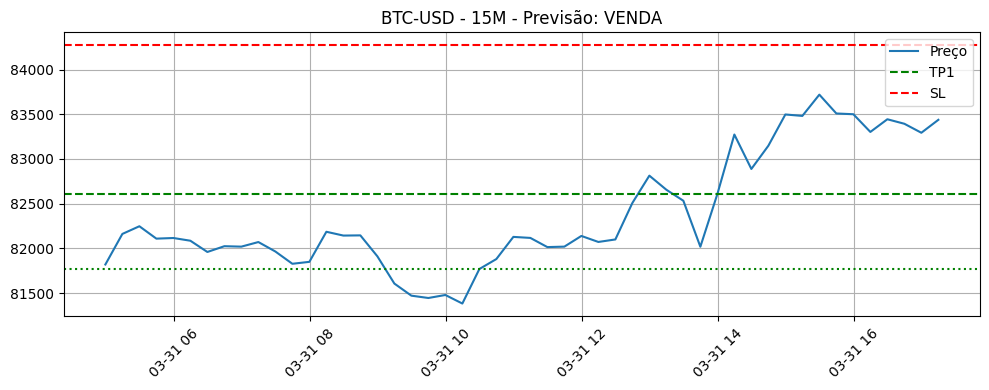


📁 Resultados salvos em: model_results_2025-03-31_17-14-33.csv
📚 Log de previsões atualizado em: /content/prediction_log.csv

⚠️ Nenhum sinal de compra com confiança > 60% para backtest.


In [15]:
#Teste manual da análise de 15 minutos
run_analysis(
    selected_timeframes=[{"interval": "15m", "period": "30d", "atr": 0.02}],
    plot_timeframes=["15m"],
    alert_timeframes=["15m"]
)
